[View in Colaboratory](https://colab.research.google.com/github/HeeYoungK/tutorial/blob/master/Tutorial_180807_XGBoost.ipynb)

# XGBoost 분산형 그래디언트 부스팅 알고리즘

## 부스팅 알고리즘

**: 약한 예측모형들을 결합하여 강한 예측모형을 만드는 알고리즘**

- 배깅*(학습데이터를 랜덤으로 샘플링하여 여러개의 bag으로 분할하고, 각 bag별로 모델을 학습한 후, 각 결과를 합하여 최종 결과를 추출)*과 유사하게 초기 샘플데이터로 다수의 분류기를 만들지만 배깅과 다르게 순차적

- 랜덤포레스트의 배깅과는 다르게 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듦

 (Bagging에서 데이터를 단순히 샘플링해서 각 모델에 적용한다면, Boosting은 이전 모델들이 예측하지 못한 Error 데이터에 가중치를 부여하여, 다음 모델이 더 잘 예측하도록 함)

- 결정트리(Decision Tree) 알고리즘의 연장선에 있음

- 분류와 회귀에 사용할 수 있음

- 무작위성이 없으며 강력한 사전 가지치기를 사용

- 참고 : [앙상블(Ensemble)-부스팅(Boosting)][https://www.slideshare.net/freepsw/boosting-bagging-vs-boosting]

- [boosting 기법 이해 (bagging vs boosting)][http://www.birc.co.kr/2017/02/06/%EC%95%99%EC%83%81%EB%B8%94ensemble-%EB%B6%80%EC%8A%A4%ED%8C%85boosting/]

# 국민청원 데이터로 청원 카테고리 분류하기
### 기존 분류에 기타 카테고리를 다른 카테고리로 예측하는 코드 추가
### XGBoost로 예측 추가
* 청와대 국민청원 : https://www1.president.go.kr/petitions
* 학습세트의 카테고리를 바탕으로 테스트 세트의 청원 카테고리를 분류해 봅니다.
* `기타`로 설정된 카테고리를 텍스트 데이터로 예측해서 보정해 주고 다시 카테고리를 예측해 봅니다.

1. 학습세트와 테스트세트를 7:3으로 임의로 나누기
1. 데이터 전처리
1. 단어 벡터화(BOW, TF-IDF)
 *  기타 청원과 아닌 것 나누기
 *  기타 청원 분류하기
 * 예측값을 category_pred 컬럼에 넣어주기
1. 분류기 설정하기(RF, XGB)
1. 분류기로 학습시키기(RF, XGB)
1. 학습의 정확도 보기(RF, XGB)
1. 테스트 데이터 예측하기(RF, XGB)
1. 실제 데이터와 예측결과의 차이를 보기(RF, XGB)

In [0]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.22.0
1.14.5


In [0]:
# 나눔글꼴 설치
!apt install fonts-nanum

# Plotnine 패키지 설치
!pip install plotnine

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

# 레티나 디스플레이 지원
%config InlineBackend.figure_format = 'retina'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20161025-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


# 데이터 로드하기

In [0]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition.csv',
                        parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(227695, 8)

In [0]:
petitions.describe()

,article_id,answered,votes
count,227695.000000,227695.000000,227695.000000
mean,138271.072742,0.000119,150.342805
std,86707.420518,0.010889,4623.328120
min,21.000000,0.000000,0.000000
25%,59499.500000,0.000000,1.000000
50%,136585.000000,0.000000,3.000000
75%,211732.500000,0.000000,11.000000
max,294835.000000,1.000000,714875.000000


In [0]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 
df = petitions.loc[(petitions['votes'] > 1000)].copy()
df.shape

(2010, 8)

In [0]:
df.describe()

,article_id,answered,votes
count,2010.000000,2010.000000,2010.000000
mean,152622.447761,0.013433,14958.180597
std,83644.787773,0.115148,46912.679522
min,28.000000,0.000000,1002.000000
25%,77220.000000,0.000000,1595.250000
50%,159952.000000,0.000000,2899.000000
75%,221442.000000,0.000000,7634.750000
max,294761.000000,1.000000,714875.000000


In [0]:
category_count = df['category'].value_counts()
category_count

인권/성평등         267
육아/교육          213
보건복지           200
안전/환경          193
정치개혁           183
기타             157
문화/예술/체육/언론    142
교통/건축/국토       141
행정              99
외교/통일/국방        91
일자리             89
반려동물            79
경제민주화           72
미래              36
성장동력            21
저출산/고령화대책       16
농산어촌            11
Name: category, dtype: int64

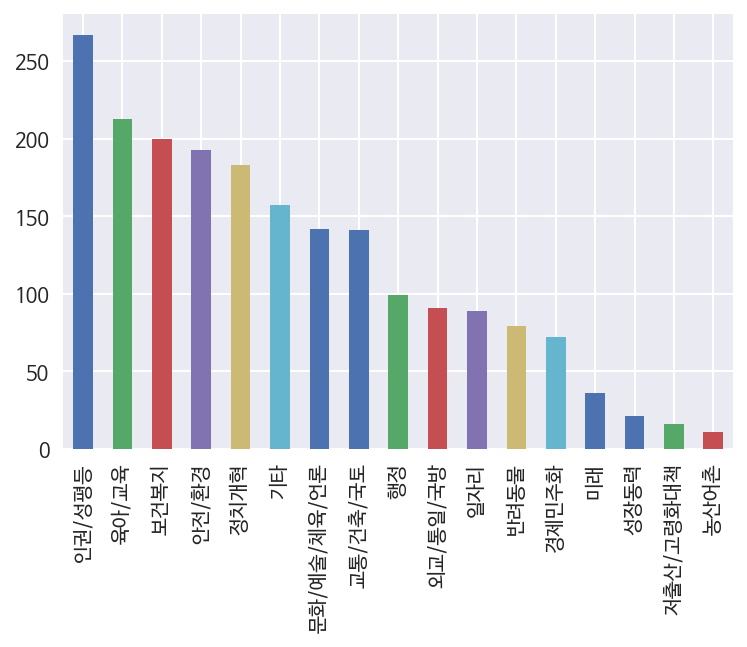

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'NanumBarunGothic'
category_count.plot(kind='bar')

In [0]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [0]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리


In [0]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = 7
sample_index

7

In [0]:
sample_title = df['title'][sample_index]
sample_title

'소액주주를 보호해주십시오'

In [0]:
sample_content = petitions['content'][sample_index]
sample_content

'**  존경하옵는 문재인대통령님께\\n저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니다. 중국원양자원(이하 중원)은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고 있습니다.\\n상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수 있습니다.\\n결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 및 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다.\\n이로인해 약 2만 5천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다.\\n주식투자는 개인의 판단하에 이루어지는 것이나 투자에 대한 개인의 책임을 묻기전에 그 과정은 규정과 상식에 맞게 공정하고 정의로워야 할 것입니다. 이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템, 특히 거래소와 회계감사는 그렇지 못한 것 같습니다.\\n이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다\\n이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 많은 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고 있습니다. .\\n기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 대한 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야 합니다.\\n그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의\'결정적 이유\'로 명시하였는바 이는 감사자의 \'의견거절\'에 따른 참혹한 결과로 볼때 

# 전처리 하기 

In [0]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [0]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '그', '있는', '있습니다','년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [0]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [0]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [0]:
pre_sample_content

'    존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다  중국원양자원 이하 중원 은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고  상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수  결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다  이로인해 약  만  천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다  주식투자는 개인의 판단하에 이루어지는 것이나 투자에 개인의 책임을 묻기전에 과정은 규정과 상식에 맞게 공정하고 정의로워야 것입니다  이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템  특히 거래소와 회계감사는 그렇지 못한 것  이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다 이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고    기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야  그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의 결정적 이유 로 명시하였는바 이는 감사자의  의견거절 에 따른 참혹한 결과로 볼때      명의 국민들과 가족들은 공정한 감사결과라 절대로 인정할수  고통의 원인은 법 제도나 규정에 근거를 두지 않

In [0]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 164 ms, sys: 677 µs, total: 165 ms
Wall time: 166 ms


In [0]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 346 ms, sys: 0 ns, total: 346 ms
Wall time: 345 ms


# 기계학습으로 기타 제거하기
* 기타로 분류된 청원중에 특정 카테고리로 분류해 주면 좀 더 정확도가 높아질 것이라는 가설을 세워봅니다.
* 따라서 기타로 분류된 청원을 다른 청원을 바탕으로 학습시켜 분류해 봅니다.

In [0]:
df['category_pred'] = df['category'].copy()

In [0]:
df_not_etc = df.loc[df['category'] != '기타'].copy()
df_etc = df.loc[df['category'] == '기타'].copy()
print(df_not_etc.shape)
print(df_etc.shape)

(1853, 11)
(157, 11)


## 기타 청원 분류하기 벡터화
* tfidf 를 사용해 벡터화 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
=stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:
%%time 
df_not_etc_vector = vectorizer.fit_transform(df_not_etc['content_preprocessing2'])
df_not_etc_vector.shape

CPU times: user 6.27 s, sys: 190 ms, total: 6.46 s
Wall time: 6.46 s


In [0]:
%%time 
df_etc_vector = vectorizer.fit_transform(df_etc['content_preprocessing2'])
df_etc_vector.shape

CPU times: user 520 ms, sys: 9.1 ms, total: 529 ms
Wall time: 529 ms


In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [0]:
%%time 
df_not_etc_tfidf = transformer.fit_transform(df_not_etc_vector)
df_not_etc_tfidf.shape

CPU times: user 5.43 ms, sys: 700 µs, total: 6.13 ms
Wall time: 6.13 ms


In [0]:
%%time 
df_etc_tfidf = transformer.fit_transform(df_etc_vector)
df_etc_tfidf.shape

CPU times: user 2.43 ms, sys: 2.1 ms, total: 4.53 ms
Wall time: 5.18 ms


## 기타 청원 분류하기

In [0]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [0]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_not_etc['category']
%time forest = forest.fit(df_not_etc_tfidf, y_label)

CPU times: user 3.89 s, sys: 13.9 ms, total: 3.91 s
Wall time: 2.1 s


In [0]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(df_etc_tfidf)
y_pred[:3]

array(['육아/교육', '반려동물', '인권/성평등'], dtype=object)

In [0]:
df_etc['category_pred'] = y_pred
df_etc['category_pred'].value_counts()

인권/성평등         44
육아/교육          31
정치개혁           21
안전/환경          18
보건복지           17
반려동물           11
경제민주화           6
일자리             4
교통/건축/국토        3
외교/통일/국방        1
문화/예술/체육/언론     1
Name: category_pred, dtype: int64

## 기타 청원 분류 결과의 일부를 미리보기

In [0]:
df_etc[['votes', 'title', 'content', 'category', 'category_pred']].head(10)

,votes,title,content,category,category_pred
345,1126,문재인 대통령 기념 시계도 판매하라.,문재인 대통령 싸인이 들어간 기념 시계를 판매용으로 전환하여 주세요. SNS상의 국...,기타,육아/교육
487,2749,2017년 10월 원천세 신고기한 및 9월분 전자세금계산서 발행기한일을 10월 13...,2017년 추석연휴 및 10월 2일 임시공휴일 지정이 확정됨에 따라 10월 초에 법...,기타,반려동물
12747,1841,억울한죽음으로 돌아가신 고 이길연집배원의 순직을요구합니다,9월5일 서광주우체국에 근속중이신 고 이길연집배원 저희아버지가 자택에서 홀로목숨을끈...,기타,인권/성평등
15456,1705,화훼도매시장 출입에 대한 출입증 발급을 청원합니다,화훼쪽에 종사하고 있는 사람입니다\n김영란법이 터지고 나서 뉴스를 보면 양재화훼시장...,기타,인권/성평등
17150,1078,TNS홀딩스 강태욱 대표 사기 횡령 사건 해결을 부탁드립니다.,안녕하세요\n영등포구에 거주하는 30살 직장인입니다.\n2014년부터 알고지낸 재무...,기타,인권/성평등
19072,123530,'일간베스트'사이트를 폐지해주세요,"국민들을 불편하게하고, 주변에 민폐를 끼치기로 유명한 일베는 사회적이슈로도 자주 떠...",기타,외교/통일/국방
22162,2452,경찰들의 성교육 이수 및 가중처벌,최근 경찰의 성폭행 성추행 성희롱등 그 주체가 범죄를 다루고 있는 경찰이된 사건들이...,기타,안전/환경
22375,2684,튜닝카 법 개정,차량튜닝에대한 법 개정이 필요할것같습니다. 요즘 튜닝사업이 확대되는 시대 입니다. ...,기타,인권/성평등
22551,2278,을지대학교병원지부 노동조합 파업사태 해결 촉구,"문재인 대통령께\n안녕하세요 대통령님, 저는 대전 을지대학교병원에 근무하는 병원노동...",기타,보건복지
23292,1470,우리나라 법은 도대체 누구를 위한 법입니까 법 개선과 피해자를 위한 제도마련이 필요...,안녕하세요 .\n오늘도 국민들을 위해 나라에 힘써주시느라 너무나 고생이 많으십니다....,기타,육아/교육


## 기타 카테고리로 분류한 데이터를 다시 합쳐 줍니다. 

In [0]:
df2 = pd.concat([df_not_etc, df_etc])
df2.shape

(2010, 11)

In [0]:
df2['category_pred'].value_counts()

인권/성평등         311
육아/교육          244
보건복지           217
안전/환경          211
정치개혁           204
교통/건축/국토       144
문화/예술/체육/언론    143
행정              99
일자리             93
외교/통일/국방        92
반려동물            90
경제민주화           78
미래              36
성장동력            21
저출산/고령화대책       16
농산어촌            11
Name: category_pred, dtype: int64

# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [0]:
df2 = df2.reindex()
df2.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [0]:
df2.shape

(2010, 11)

In [0]:
split_count = int(df2.shape[0] * 0.7)
split_count

1407

In [0]:
df_train = df2[:split_count].copy()
df_train.shape

(1407, 11)

In [0]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [0]:
df_test = df2[split_count:].copy()
df_test.shape

(603, 11)

In [0]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
179796,224861,2018-05-05,2018-06-04,0,2339,문화/예술/체육/언론,만민중앙교회 이재록 목사 공정조사 청원,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,문화/예술/체육/언론,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,만민중앙교회 당회장 이재록 목사님에 거짓 증언과 거짓 보도에 공정한 조사를 청원합니...
179842,224921,2018-05-05,2018-06-04,0,4824,인권/성평등,"신안염전노예사건의 전면 재수사와, 당시 솜방망이 판결을 내린 판사들에 대한 처벌을...",5월5일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다\n신...,인권/성평등,월 일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안...,그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안 염전에...
180244,225457,2018-05-06,2018-06-05,0,1737,인권/성평등,강제적으로 제출한 취하장으로 인해 가해자를 제대로 처벌하지 못하는 점 개선시키고 싶...,안녕하세요. 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,인권/성평등,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...
180246,225462,2018-05-06,2018-06-05,0,1025,정치개혁,뇌물수뢰 의혹이 있는 부패한 정치인 최대호 더불어민주당 안양시장 후보의 자격 박탈을...,최대호 더불어민주당 안양시장 후보는 안양시장 재직(2010년 7월~2014년 6월)...,정치개혁,최대호 더불어민주당 안양시장 후보는 안양시장 재직 년 월 년 월 ...,최대호 더불어민주당 안양시장 후보는 안양시장 재직 년 년 당시 ...
180330,225641,2018-05-06,2018-06-05,0,4565,정치개혁,국회해산 및 재구성,"4월 한 달을 꼬박~!!!\n단 한 번의 회의도,\n단 한 건의 법안도 처리하지 않...",정치개혁,월 한 달을 꼬박 단 한 번의 회의도 단 한 건의 법안도 처리하지 않은 ...,달을 꼬박 단 번의 회의도 단 건의 법안도 처리하지 않은 국회는 누구를 ...


## 카테고리 

* 예측한 카테고리의 비율을 봅니다.

In [0]:
df_category_value = pd.DataFrame(df2['category_pred'].value_counts())
df_category_percent = pd.DataFrame(df2['category_pred'].value_counts(normalize=True))
df_category = df_category_value.merge(df_category_percent, left_index=True, right_index=True)
df_category.columns = ['청원수', '청원비율']
df_category

,청원수,청원비율
인권/성평등,311,0.154726
육아/교육,244,0.121393
보건복지,217,0.107960
안전/환경,211,0.104975
정치개혁,204,0.101493
교통/건축/국토,144,0.071642
문화/예술/체육/언론,143,0.071144
행정,99,0.049254
일자리,93,0.046269
외교/통일/국방,92,0.045771


## 학습데이터의 카테고리

In [0]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category = df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)
df_train_category.columns = ['청원수', '청원비율']
df_train_category

,청원수,청원비율
인권/성평등,180,0.127932
보건복지,166,0.117982
육아/교육,153,0.108742
안전/환경,145,0.103056
정치개혁,137,0.097370
문화/예술/체육/언론,127,0.090263
교통/건축/국토,113,0.080313
일자리,75,0.053305
행정,71,0.050462
외교/통일/국방,62,0.044065


## 테스트 데이터의 카테고리

In [0]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category = df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)
df_test_category.columns = ['청원수', '청원비율']
df_test_category

,청원수,청원비율
기타,157,0.260365
인권/성평등,87,0.144279
육아/교육,60,0.099502
안전/환경,48,0.079602
정치개혁,46,0.076285
보건복지,34,0.056385
외교/통일/국방,29,0.048093
교통/건축/국토,28,0.046434
행정,28,0.046434
반려동물,23,0.038143


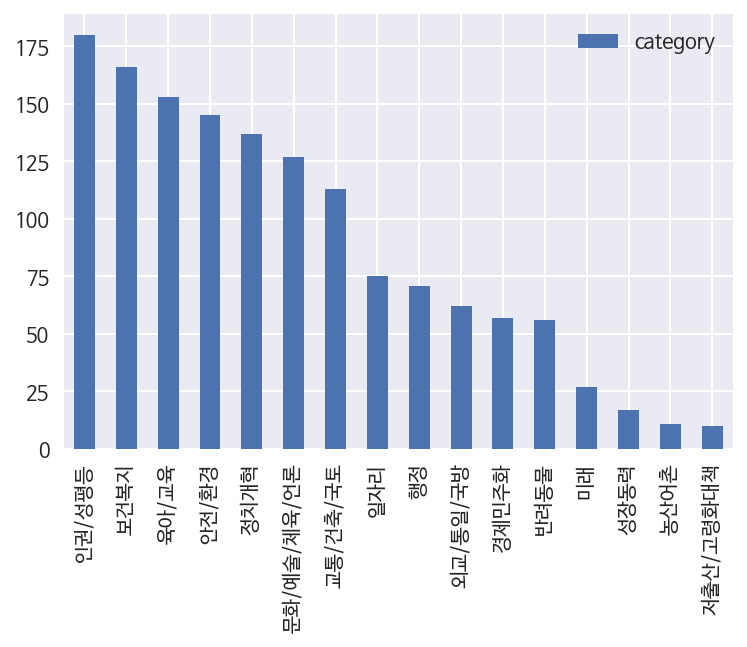

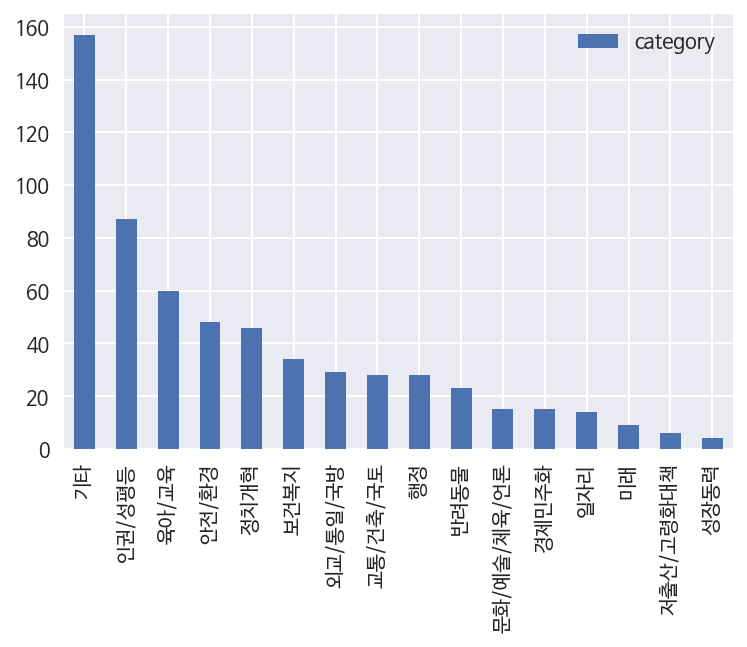

In [0]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 4.74 s, sys: 128 ms, total: 4.87 s
Wall time: 4.86 s


In [0]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 2.28 s, sys: 44.4 ms, total: 2.32 s
Wall time: 2.33 s


In [0]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'articleview',
 'articleview idxno',
 'be',
 'blog',
 'cctv',
 'cctv를',
 'co',
 'co kr',
 'co kr news']

In [0]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,articleview,articleview idxno,be,blog,cctv,cctv를,co,co kr,co kr news,...,훨씬,휴게,휴게시간,휴게시간을,희망을,힘든,힘들게,힘들어,힘을,힘이
0,44,46,46,105,99,52,177,40,38,22,...,50,31,80,44,23,23,23,23,53,37


In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [0]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 4.03 ms, sys: 1.01 ms, total: 5.04 ms
Wall time: 6.29 ms


In [0]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 4.43 ms, sys: 61 µs, total: 4.49 ms
Wall time: 4.71 ms


In [0]:
test_feature_tfidf.shape

(603, 2000)

In [0]:
from collections import Counter
dict(Counter(vocab).most_common(30))

{'aid': 1,
 'articleview': 1,
 'articleview idxno': 1,
 'be': 1,
 'blog': 1,
 'cctv': 1,
 'cctv를': 1,
 'co': 1,
 'co kr': 1,
 'co kr news': 1,
 'com': 1,
 'com main': 1,
 'com main read': 1,
 'com news': 1,
 'com news articleview': 1,
 'daum': 1,
 'daum net': 1,
 'do': 1,
 'http': 1,
 'http media': 1,
 'http media daum': 1,
 'http news': 1,
 'http news naver': 1,
 'http www': 1,
 'https': 1,
 'https www': 1,
 'id': 1,
 'idxno': 1,
 'it': 1,
 'kbs': 1}

## 예측한 카테고리를 label로 사용하기

In [0]:
# 학습에 사용할 y_label 을 넣어줍니다. 기타를 제거한 카테고리 데이터를 사용합니다.
y_label = df_train['category_pred']

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [0]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [0]:
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 2.63 s, sys: 22.5 ms, total: 2.65 s
Wall time: 1.49 s


## XGBoost로 학습시키기

In [0]:
!pip install xgboost

In [0]:
import xgboost as xgb

# XGBoost Parameters http://xgboost.readthedocs.io/en/latest/parameter.html
xgb = xgb.XGBClassifier(n_estimators=10,
                          max_depth=6,
                          learning_rate=1.0,
                          max_delta_step=1,
                          eta = 1,
                          nthread=-1,
                          seed=2018)
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=1.0,
       max_delta_step=1, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2018, silent=True, subsample=1)

In [0]:
%time xgb.fit(train_feature_tfidf, y_label)

CPU times: user 4.84 s, sys: 14.8 ms, total: 4.86 s
Wall time: 2.46 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=1.0,
       max_delta_step=1, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=-1, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2018, silent=True, subsample=1)

# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면, (feat.애란쌤)
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

## RF 평가

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 232 ms, sys: 55 ms, total: 287 ms
Wall time: 4.49 s


array([0.41843972, 0.44326241, 0.41281139, 0.42348754, 0.46263345])

In [0]:
round(np.mean(score)*100,2)

43.21

## xgb 평가

In [0]:
%time score_xgb = cross_val_score(xgb, train_feature_tfidf, y_label, scoring="accuracy").mean()
print(round(np.mean(score_xgb)*100,2))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 8.99 s, sys: 33.5 ms, total: 9.02 s
Wall time: 4.56 s
32.64


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 예측
## RF

In [0]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['교통/건축/국토', '반려동물', '경제민주화'], dtype=object)

In [0]:
y_pred.shape

(603,)

## XGB

In [0]:
y_pred_xgb = xgb.predict(test_feature_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
print(y_pred_xgb.shape)
df_test['category_pred_xgb'] = y_pred_xgb
y_pred_xgb[:5]

(603,)


array(['안전/환경', '반려동물', '경제민주화', '보건복지', '안전/환경'], dtype=object)

In [0]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,교통/건축/국토
1,반려동물
2,경제민주화
3,보건복지
4,안전/환경


### RF로 예측한 카테고리

In [0]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

육아/교육          146
보건복지           102
안전/환경           94
인권/성평등          65
경제민주화           49
반려동물            37
정치개혁            33
교통/건축/국토        31
문화/예술/체육/언론     29
외교/통일/국방         9
일자리              7
행정               1
Name: category_pred, dtype: int64

### XGB로 예측한 카테고리

In [0]:
df_test['category_pred_xgb'].value_counts()

인권/성평등         130
육아/교육           97
반려동물            75
안전/환경           66
보건복지            54
문화/예술/체육/언론     53
교통/건축/국토        37
정치개혁            36
행정              16
일자리             15
경제민주화           14
외교/통일/국방         7
미래               3
Name: category_pred_xgb, dtype: int64

In [0]:
df_test['category_pred'] = y_pred

In [0]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head(3)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff
179796,224861,2018-05-05,2018-06-04,0,2339,문화/예술/체육/언론,만민중앙교회 이재록 목사 공정조사 청원,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,교통/건축/국토,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,만민중앙교회 당회장 이재록 목사님에 거짓 증언과 거짓 보도에 공정한 조사를 청원합니...,안전/환경,0
179842,224921,2018-05-05,2018-06-04,0,4824,인권/성평등,"신안염전노예사건의 전면 재수사와, 당시 솜방망이 판결을 내린 판사들에 대한 처벌을...",5월5일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다\n신...,반려동물,월 일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안...,그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안 염전에...,반려동물,0
180244,225457,2018-05-06,2018-06-05,0,1737,인권/성평등,강제적으로 제출한 취하장으로 인해 가해자를 제대로 처벌하지 못하는 점 개선시키고 싶...,안녕하세요. 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,경제민주화,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,경제민주화,0


In [0]:
df_test['pred_diff_xgb'] = 0
df_test['pred_diff_xgb'] = (df_test['category'] == df_test['category_pred_xgb'] ) == 1
df_test['pred_diff_xgb'] = df_test['pred_diff_xgb'].astype(int)
df_test.head(3)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
179796,224861,2018-05-05,2018-06-04,0,2339,문화/예술/체육/언론,만민중앙교회 이재록 목사 공정조사 청원,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,교통/건축/국토,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,만민중앙교회 당회장 이재록 목사님에 거짓 증언과 거짓 보도에 공정한 조사를 청원합니...,안전/환경,0,0
179842,224921,2018-05-05,2018-06-04,0,4824,인권/성평등,"신안염전노예사건의 전면 재수사와, 당시 솜방망이 판결을 내린 판사들에 대한 처벌을...",5월5일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다\n신...,반려동물,월 일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안...,그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안 염전에...,반려동물,0,0
180244,225457,2018-05-06,2018-06-05,0,1737,인권/성평등,강제적으로 제출한 취하장으로 인해 가해자를 제대로 처벌하지 못하는 점 개선시키고 싶...,안녕하세요. 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,경제민주화,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,경제민주화,0,0


In [0]:
# RF로 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    554
1     49
Name: pred_diff, dtype: int64

In [0]:
# XGB로 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff_xgb = df_test['pred_diff_xgb'].value_counts()
pred_diff_xgb

0    559
1     44
Name: pred_diff_xgb, dtype: int64

In [0]:
print('RF 전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

RF 전체 603건의 데이터 중 49건 예측


In [0]:
print('XGB 전체 {}건의 데이터 중 {}건 예측'.format(y_pred_xgb.shape[0], pred_diff_xgb[1]))

XGB 전체 603건의 데이터 중 44건 예측


In [0]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 8.12603648424544


In [0]:
acc = ( pred_diff_xgb[1] / y_pred_xgb.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 7.2968490878938645


In [0]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
181601,227378,2018-05-08,2018-06-07,0,1561,육아/교육,경기도 광주시 오포읍 신현초.능평초 설립해주세요.,경기도 광주시 오포읍에 초등학교라고는\n70년 전 분교로 개교한 광명초 하나뿐이며\...,육아/교육,경기도 광주시 오포읍에 초등학교라고는 년 전 분교로 개교한 광명초 하나뿐이며 현...,경기도 광주시 오포읍에 초등학교라고는 년 전 분교로 개교한 광명초 하나뿐이며 현...,반려동물,1,0
182631,228841,2018-05-09,2018-06-08,0,5289,보건복지,"의술로 상처 받고, 법으로 남은 희망마저 무참히 밟혀버렸습니다-의료사고 언제까지 피...",이 이야기는 9년 전 시작된 제 동생의 이야기입니다.\n2010년 6월 10일 오후...,보건복지,이 이야기는 년 전 시작된 제 동생의 이야기입니다 년 월 일 오후 ...,이 이야기는 년 전 시작된 동생의 이야기입니다 년 오후 시 분...,인권/성평등,1,0
183347,229935,2018-05-10,2018-06-09,0,3024,육아/교육,"학생들의 안전과 학습을 침해하는 영양교사, 보건교사 제도를 폐지해주세요.",저는 2개 대학을 졸업했습니다. 그래서 보건교사 자격증과 초등교사 자격증이 모두 있...,육아/교육,저는 개 대학을 졸업했습니다 그래서 보건교사 자격증과 초등교사 자격증이 모두 있...,개 대학을 졸업했습니다 그래서 보건교사 자격증과 초등교사 자격증이 모두 현직 교...,육아/교육,1,1
183929,230732,2018-05-12,2018-06-11,0,6221,보건복지,소방청은 구급대원에게 관심이 없습니다.,구급대를 소방청에서 보건복지부 산하로 들어가거나 소방조직 내에 독립적으로 분리되었으...,보건복지,구급대를 소방청에서 보건복지부 산하로 들어가거나 소방조직 내에 독립적으로 분리되었으...,구급대를 소방청에서 보건복지부 산하로 들어가거나 소방조직 내에 독립적으로 분리되었으...,육아/교육,1,0
184906,232229,2018-05-14,2018-06-13,0,1072,육아/교육,스승이 없는 스승의 날은 차라리 폐지 또는 휴일지정 하여 주십시오.,"17년차 고등학교 교사입니다.\n내일이면 스승의 날입니다.\n하지만, 교육 현장에 ...",육아/교육,년차 고등학교 교사입니다 내일이면 스승의 날입니다 하지만 교육 현장에 스승...,년차 고등학교 교사입니다 내일이면 스승의 날입니다 하지만 교육 현장에 스승...,외교/통일/국방,1,0


In [0]:
predict_incorrect = df_test.loc[df_test['pred_diff_xgb'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
179796,224861,2018-05-05,2018-06-04,0,2339,문화/예술/체육/언론,만민중앙교회 이재록 목사 공정조사 청원,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,교통/건축/국토,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...,만민중앙교회 당회장 이재록 목사님에 거짓 증언과 거짓 보도에 공정한 조사를 청원합니...,안전/환경,0,0
179842,224921,2018-05-05,2018-06-04,0,4824,인권/성평등,"신안염전노예사건의 전면 재수사와, 당시 솜방망이 판결을 내린 판사들에 대한 처벌을...",5월5일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다\n신...,반려동물,월 일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안...,그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다 신안 염전에...,반려동물,0,0
180244,225457,2018-05-06,2018-06-05,0,1737,인권/성평등,강제적으로 제출한 취하장으로 인해 가해자를 제대로 처벌하지 못하는 점 개선시키고 싶...,안녕하세요. 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,경제민주화,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,안녕하세요 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...,경제민주화,0,0
180246,225462,2018-05-06,2018-06-05,0,1025,정치개혁,뇌물수뢰 의혹이 있는 부패한 정치인 최대호 더불어민주당 안양시장 후보의 자격 박탈을...,최대호 더불어민주당 안양시장 후보는 안양시장 재직(2010년 7월~2014년 6월)...,보건복지,최대호 더불어민주당 안양시장 후보는 안양시장 재직 년 월 년 월 ...,최대호 더불어민주당 안양시장 후보는 안양시장 재직 년 년 당시 ...,보건복지,0,0
180330,225641,2018-05-06,2018-06-05,0,4565,정치개혁,국회해산 및 재구성,"4월 한 달을 꼬박~!!!\n단 한 번의 회의도,\n단 한 건의 법안도 처리하지 않...",안전/환경,월 한 달을 꼬박 단 한 번의 회의도 단 한 건의 법안도 처리하지 않은 ...,달을 꼬박 단 번의 회의도 단 건의 법안도 처리하지 않은 국회는 누구를 ...,안전/환경,0,0


In [0]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

기타             157
인권/성평등          70
육아/교육           52
정치개혁            45
안전/환경           41
보건복지            32
외교/통일/국방        28
행정              27
교통/건축/국토        26
반려동물            20
문화/예술/체육/언론     15
경제민주화           14
일자리             13
미래               9
저출산/고령화대책        6
성장동력             4
Name: category, dtype: int64

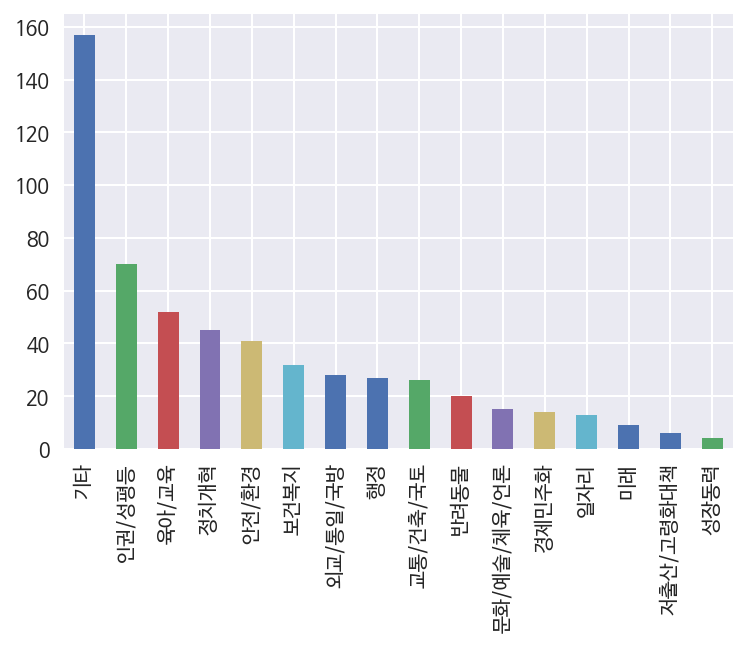

In [0]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [0]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
179796,문화/예술/체육/언론,교통/건축/국토,만민중앙교회 이재록 목사 공정조사 청원,만민중앙교회 당회장 이재록 목사님에 대한 거짓 증언과 거짓 보도에 대한 공정한 조사...
179842,인권/성평등,반려동물,"신안염전노예사건의 전면 재수사와, 당시 솜방망이 판결을 내린 판사들에 대한 처벌을...",5월5일 그것이 알고싶다에 나온 신안 염전 노예사건 방송은 충격 또 충격입니다\n신...
180244,인권/성평등,경제민주화,강제적으로 제출한 취하장으로 인해 가해자를 제대로 처벌하지 못하는 점 개선시키고 싶...,안녕하세요. 제가 올린 청원글이 분량이 길고 부족한 점이 많더라도 끝까지 정독하여 ...
180246,정치개혁,보건복지,뇌물수뢰 의혹이 있는 부패한 정치인 최대호 더불어민주당 안양시장 후보의 자격 박탈을...,최대호 더불어민주당 안양시장 후보는 안양시장 재직(2010년 7월~2014년 6월)...
180330,정치개혁,안전/환경,국회해산 및 재구성,"4월 한 달을 꼬박~!!!\n단 한 번의 회의도,\n단 한 건의 법안도 처리하지 않..."
180333,육아/교육,인권/성평등,"프랑스처럼 청소년 스마트폰 금지령을 법으로 제정헤주세요,,",우리의 청소년을 핸드폰의 노예가 되지않게 해주세요..\n올 가을부터 프랑스에...
180420,반려동물,안전/환경,반려동물 병원비를 현실적이고 일정하게 정부에서 책정해주세요.반려인들이 힘듭니다.,반려동물이 아파 동물병원에서 진료후 진료비 청구내역에 기절 할뻔 하였습니다.\n병원...
180544,교통/건축/국토,경제민주화,분양대행업에관한 건설면허,분양대행을 하기위해서는 건설면허를 해야한다는데 분양대행이랑 건설면허는 아무 상관도 ...
180707,안전/환경,육아/교육,5월 8일 어버이날 아이를 떠나 보내야 했습니다. 특별사면 재검토 청원합니다.,특별사면에 대한 재검토 요청합니다!\n아울러 교통사고처리 특례법에 대한 개정 요청드...
180745,정치개혁,육아/교육,대구시장 권영진의 선거법 무시 및 무능한 선관위를 철저히 조사해 징계해 주십시오,대구시장 권영진은 대구에서 자신의 직위를 이용하여 대구 선관위를 좌지우지 할 수 있...


## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [0]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
345,기타,반려동물,문재인 대통령 기념 시계도 판매하라.,문재인 대통령 싸인이 들어간 기념 시계를 판매용으로 전환하여 주세요. SNS상의 국...
487,기타,정치개혁,2017년 10월 원천세 신고기한 및 9월분 전자세금계산서 발행기한일을 10월 13...,2017년 추석연휴 및 10월 2일 임시공휴일 지정이 확정됨에 따라 10월 초에 법...
12747,기타,정치개혁,억울한죽음으로 돌아가신 고 이길연집배원의 순직을요구합니다,9월5일 서광주우체국에 근속중이신 고 이길연집배원 저희아버지가 자택에서 홀로목숨을끈...
15456,기타,인권/성평등,화훼도매시장 출입에 대한 출입증 발급을 청원합니다,화훼쪽에 종사하고 있는 사람입니다\n김영란법이 터지고 나서 뉴스를 보면 양재화훼시장...
17150,기타,안전/환경,TNS홀딩스 강태욱 대표 사기 횡령 사건 해결을 부탁드립니다.,안녕하세요\n영등포구에 거주하는 30살 직장인입니다.\n2014년부터 알고지낸 재무...
19072,기타,안전/환경,'일간베스트'사이트를 폐지해주세요,"국민들을 불편하게하고, 주변에 민폐를 끼치기로 유명한 일베는 사회적이슈로도 자주 떠..."
22162,기타,보건복지,경찰들의 성교육 이수 및 가중처벌,최근 경찰의 성폭행 성추행 성희롱등 그 주체가 범죄를 다루고 있는 경찰이된 사건들이...
22375,기타,경제민주화,튜닝카 법 개정,차량튜닝에대한 법 개정이 필요할것같습니다. 요즘 튜닝사업이 확대되는 시대 입니다. ...
22551,기타,육아/교육,을지대학교병원지부 노동조합 파업사태 해결 촉구,"문재인 대통령께\n안녕하세요 대통령님, 저는 대전 을지대학교병원에 근무하는 병원노동..."
23292,기타,반려동물,우리나라 법은 도대체 누구를 위한 법입니까 법 개선과 피해자를 위한 제도마련이 필요...,안녕하세요 .\n오늘도 국민들을 위해 나라에 힘써주시느라 너무나 고생이 많으십니다....


In [0]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 8.12603648424544


In [0]:
acc = ( pred_diff_xgb[1] / y_pred_xgb.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 7.2968490878938645
